# Mixed Layer Depth

In [6]:
# imports
import os
import xarray

import numpy as np
from scipy import stats
from scipy.interpolate import interp1d 

from gsw import conversions, density
import gsw

from matplotlib import pyplot as plt
import matplotlib as mpl
import matplotlib.gridspec as gridspec
import matplotlib.dates as mdates
from matplotlib.ticker import MultipleLocator 

import seaborn as sns

import pandas

from cugn import grid_utils
from cugn import utils as cugn_utils
from cugn import io as cugn_io
from cugn import annualcycle

# Load CUGN

In [2]:
line = '90.0'
#
items = cugn_io.load_up(line)#, gextrem='low')
grid_extrem = items[0]
ds = items[1]

Loading: doxy_grid_line90.parquet
Loading: doxy_grid_line90.parquet
Found 29 unique clusters


# Density profile

## Profile

np.int32(37538)

In [42]:
#iprofile=20000  # Random location

## Calculate density

In [8]:
# Characteristic lat, lon
lat = np.nanmedian(ds.lat.data)
lon = np.nanmedian(ds.lon.data)
lat, lon

(np.float64(32.619445), np.float64(-119.71646750000001))

In [33]:
def calc_density(ds, iprofile):
    # Loop on depths
    SAs, CTs = [], []
    for zz, z in enumerate(ds.depth.data):
        # Pressure
        p = conversions.p_from_z(-z, lat)
    
        # SA
        SA = conversions.SA_from_SP(ds.salinity.data[zz,iprofile], 
                                    p, lon, lat)
        # CT
        CT = conversions.CT_from_t(SA, ds.temperature.data[zz,iprofile], p)
        # Save
        SAs.append(SA)
        CTs.append(CT)
    # Densities
    sigma0 = density.sigma0(SAs, CTs)
    sigma = density.sigma0(ds.salinity.data[:,iprofile], ds.temperature.data[:,iprofile])

    # Return
    return sigma, sigma0

# MLD

In [45]:
def calc_MLD(sigma, thresh=0.125):
    # Interpolate
    f = interp1d(sigma, ds.depth.data-5.)
    # Offset
    sigma_MLD = sigma[0] + thresh
    # Finish
    return f(sigma_MLD)

## Examine

In [48]:
iprofile = grid_extrem.iloc[200].profile
iprofile

np.int32(40162)

MLD=36.8m


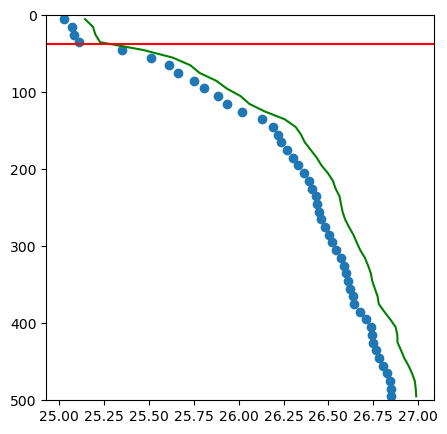

In [49]:
sigma, sigma0 = calc_density(ds, iprofile)

fig = plt.figure(figsize=(5,5))
ax = plt.gca()
#
ax.plot(sigma, ds.depth.data-5., 'o')
ax.plot(sigma0, ds.depth.data-5., color='g')

# MLD
mld = calc_MLD(sigma)
print(f'MLD={mld:0.1f}m')
ax.axhline(mld, color='red')

ax.set_ylim(ds.depth.data.max(),0.)
#
plt.show()